In [1]:
!git clone https://github.com/GerasimovSergey2001/FlowMatching.git

Cloning into 'FlowMatching'...
remote: Enumerating objects: 393, done.
remote: Counting objects: 100% (393/393), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 393 (delta 197), reused 393 (delta 197), pack-reused 0 (from 0)
Receiving objects: 100% (393/393), 281.39 KiB | 3.43 MiB/s, done.
Resolving deltas: 100% (197/197), done.


In [3]:
%cd FlowMatching/

/content/FlowMatching


In [4]:
!pip install torchdiffeq -q

In [5]:
import sys
import os

from tqdm import tqdm

import torch
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from src.model.flow_matching import FlowMatching

from src.model.base_models.unet import UNetModel


import torchvision
from torchvision.datasets import MNIST

/content/FlowMatching/src/model/flow_matching.py:51: SyntaxWarning: invalid escape sequence '\p'
  Computes \phi(t,x) = \sigma(t, x1)x + \mu(t, x1), where \phi(0,x) = x = x0


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])

def collate_only_x(batch):
    xs = [item[0] for item in batch]
    return torch.stack(xs)

dataset = MNIST('data', transform=transform, download=True)

batch_size = 256
loader = DataLoader(dataset, batch_size=batch_size, collate_fn=collate_only_x)

In [23]:
model = UNetModel(
    image_size=28,
    in_channels=1,
    model_channels=32,
    out_channels=1,
    num_res_blocks=1,
    attention_resolutions=(2,4),
    dropout=0.0,
    channel_mult=(1, 2, 2),
    num_heads=2
)

In [24]:
n_epochs = 30
lr = 1e-3
obs_dim = (1, 28, 28)
fm = FlowMatching(model, obs_dim).to(device)
optimizer = torch.optim.AdamW(fm.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=10*235, power=0.95)

Epoch 1: 235it [00:47,  4.90it/s]


Total Loss Epoch 1:  261.62674


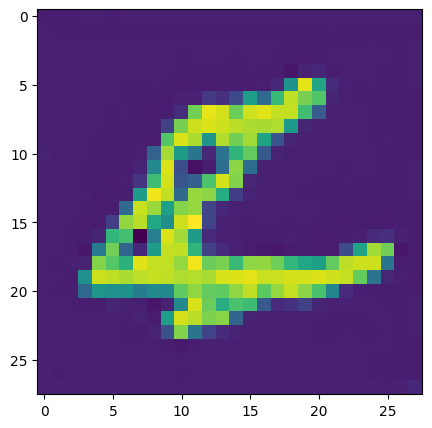

Epoch 2: 235it [00:47,  4.95it/s]


Total Loss Epoch 2:  164.12369


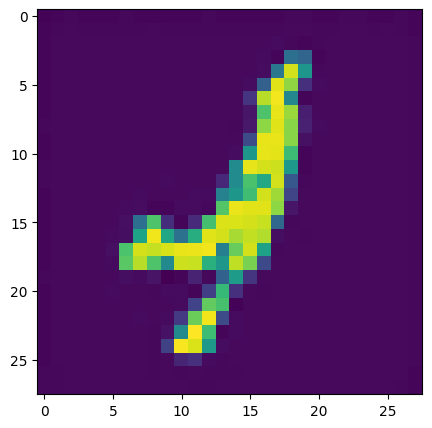

Epoch 3: 235it [00:47,  4.95it/s]


Total Loss Epoch 3:  154.8473


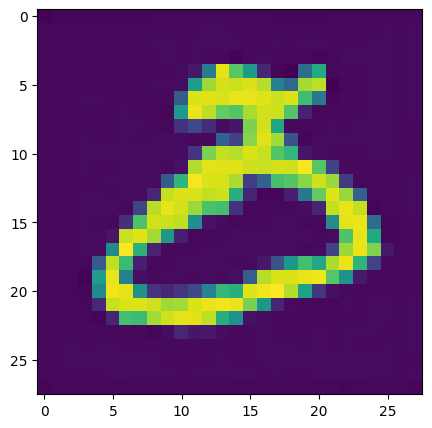

Epoch 4: 235it [00:47,  4.95it/s]


Total Loss Epoch 4:  149.98329


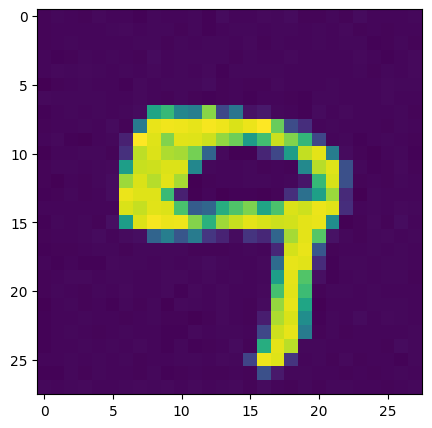

Epoch 5: 235it [00:47,  4.95it/s]


Total Loss Epoch 5:  147.3355


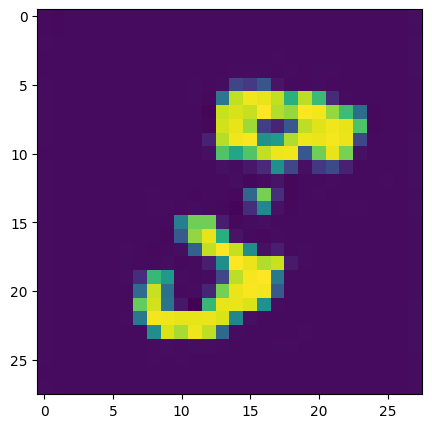

Epoch 6: 235it [00:47,  4.95it/s]


Total Loss Epoch 6:  144.31244


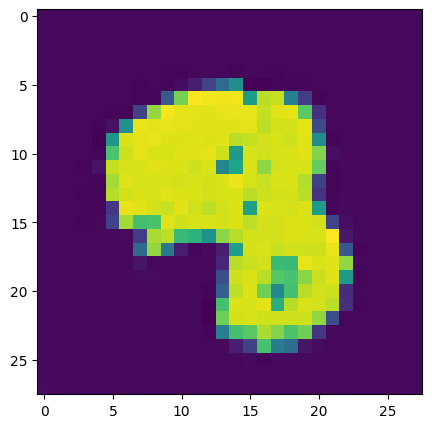

Epoch 7: 235it [00:47,  4.95it/s]


Total Loss Epoch 7:  142.64223


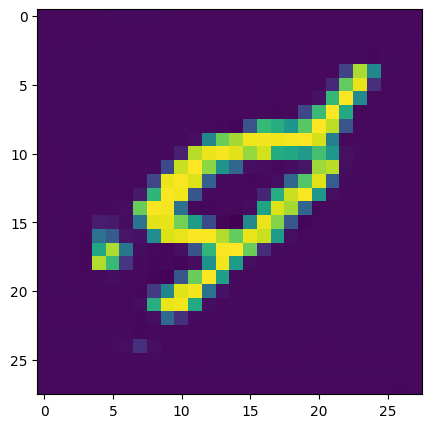

Epoch 8: 235it [00:47,  4.95it/s]


Total Loss Epoch 8:  141.60167


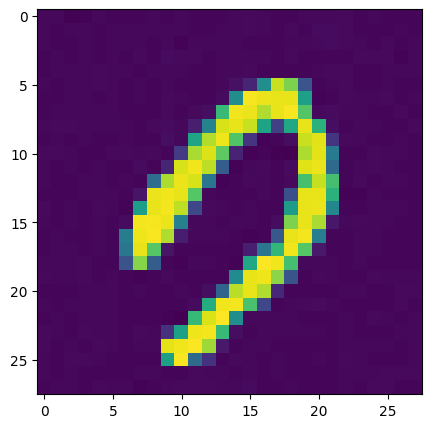

Epoch 9: 235it [00:47,  4.95it/s]


Total Loss Epoch 9:  138.92703


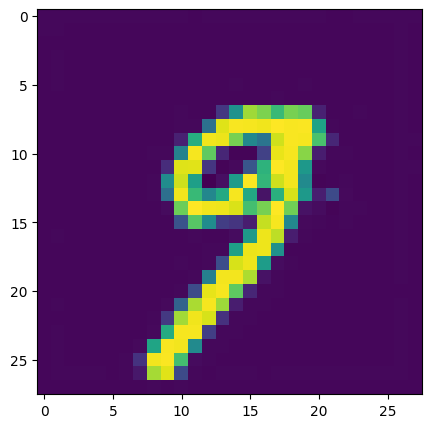

Epoch 10: 235it [00:47,  4.95it/s]


Total Loss Epoch 10:  137.85011


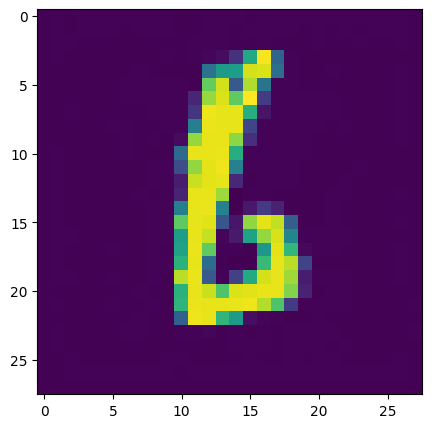

Epoch 11: 235it [00:47,  4.95it/s]


Total Loss Epoch 11:  137.61606


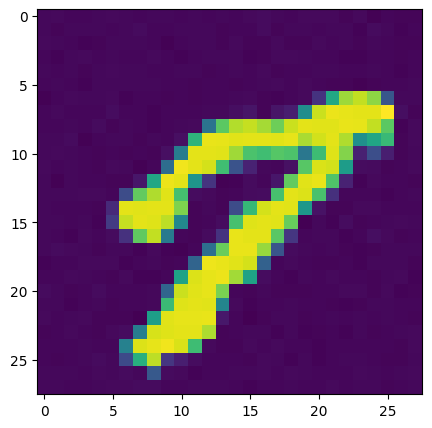

Epoch 12: 235it [00:47,  4.95it/s]


Total Loss Epoch 12:  137.02737


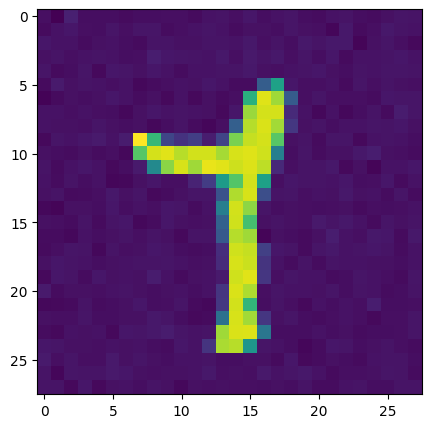

Epoch 13: 235it [00:47,  4.94it/s]


Total Loss Epoch 13:  137.2209


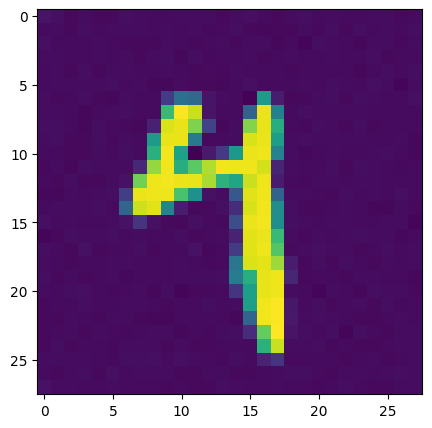

Epoch 14: 235it [00:47,  4.95it/s]


Total Loss Epoch 14:  137.68683


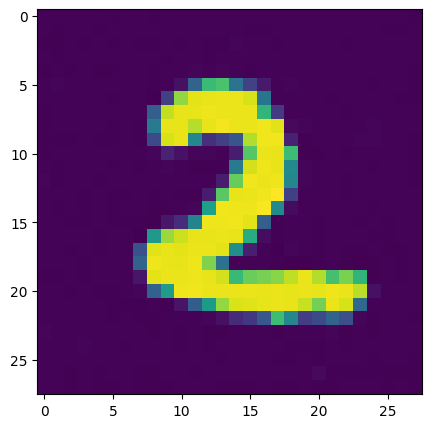

Epoch 15: 235it [00:47,  4.95it/s]


Total Loss Epoch 15:  137.32045


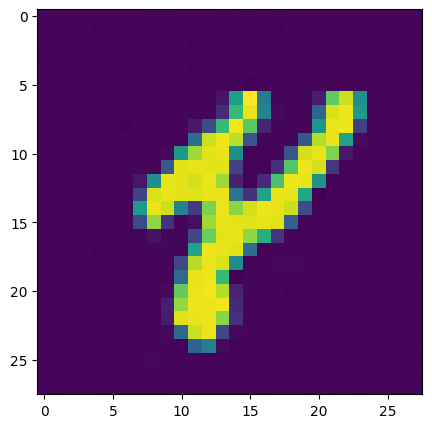

Epoch 16: 235it [00:47,  4.95it/s]


Total Loss Epoch 16:  137.06439


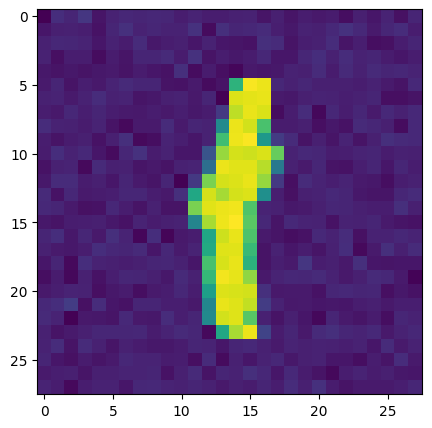

Epoch 17: 235it [00:47,  4.95it/s]


Total Loss Epoch 17:  137.17227


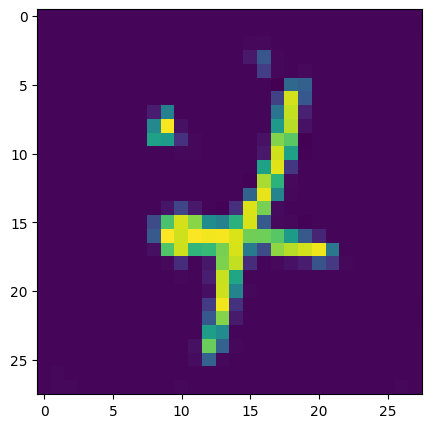

Epoch 18: 235it [00:47,  4.95it/s]


Total Loss Epoch 18:  137.2029


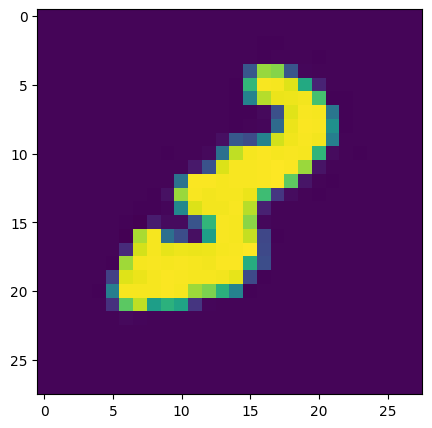

Epoch 19: 235it [00:47,  4.95it/s]


Total Loss Epoch 19:  137.20958


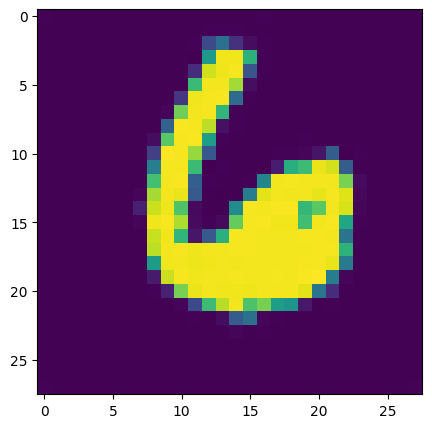

Epoch 20: 235it [00:47,  4.91it/s]


Total Loss Epoch 20:  137.46712


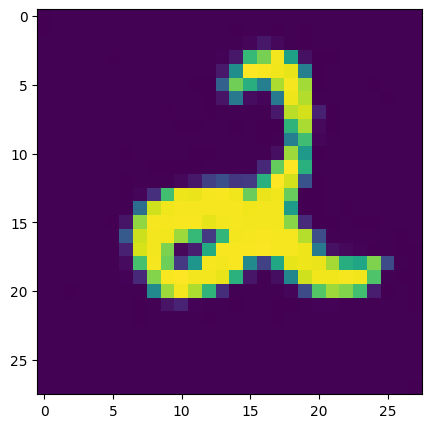

Epoch 21: 235it [00:47,  4.95it/s]


Total Loss Epoch 21:  137.1746


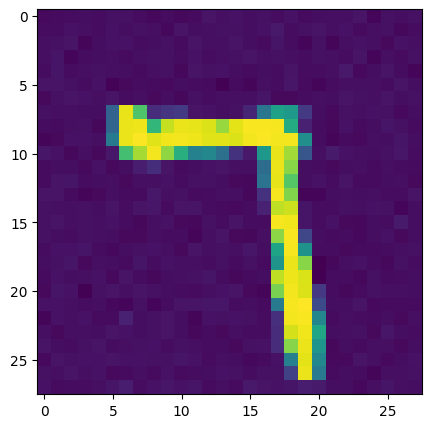

Epoch 22: 235it [00:47,  4.95it/s]


Total Loss Epoch 22:  137.61722


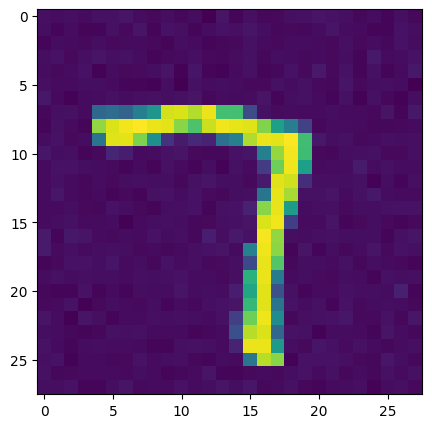

Epoch 23: 235it [00:47,  4.95it/s]


Total Loss Epoch 23:  137.00104


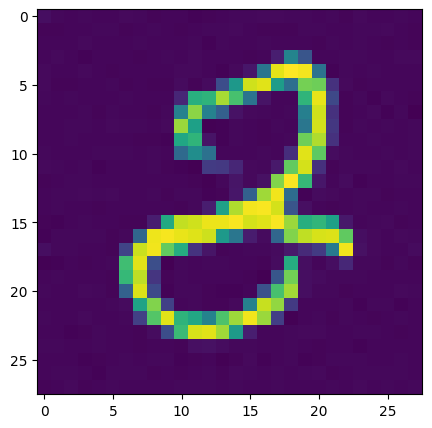

Epoch 24: 235it [00:47,  4.95it/s]


Total Loss Epoch 24:  137.17406


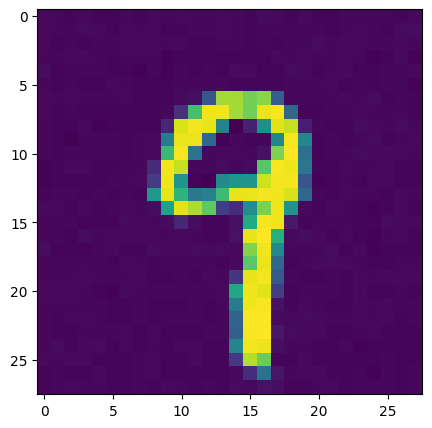

Epoch 25: 235it [00:47,  4.94it/s]


Total Loss Epoch 25:  137.3565


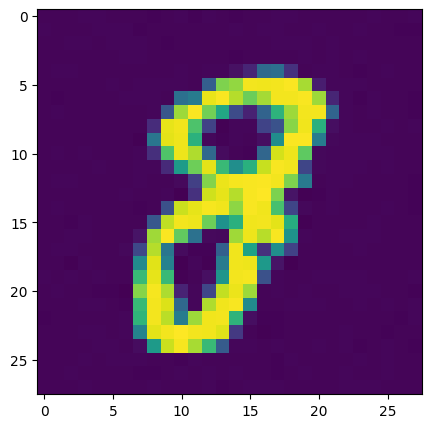

Epoch 26: 235it [00:47,  4.94it/s]


Total Loss Epoch 26:  137.79094


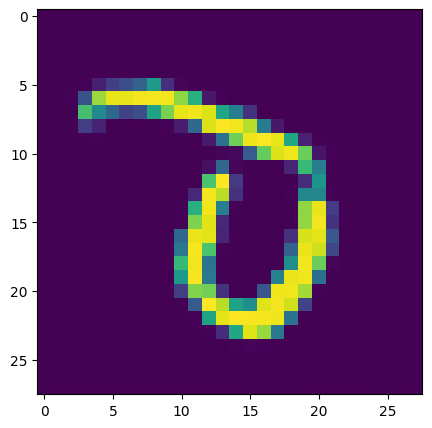

Epoch 27: 235it [00:47,  4.93it/s]


Total Loss Epoch 27:  137.25667


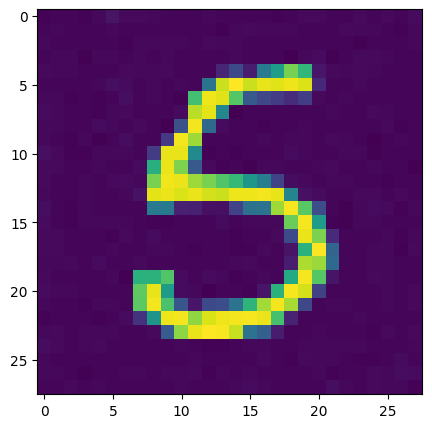

Epoch 28: 235it [00:47,  4.95it/s]


Total Loss Epoch 28:  137.90744


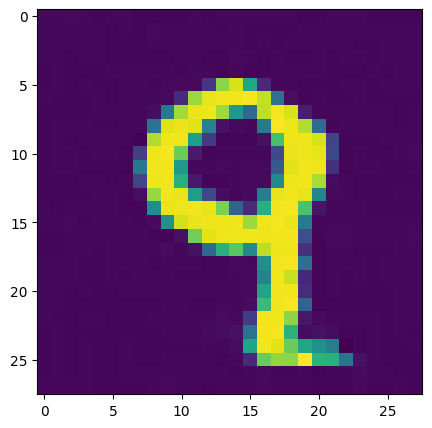

Epoch 29: 235it [00:47,  4.95it/s]


Total Loss Epoch 29:  137.4908


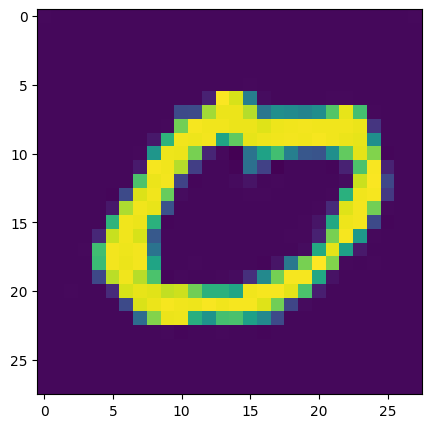

Epoch 30: 235it [00:47,  4.95it/s]


Total Loss Epoch 30:  137.7585


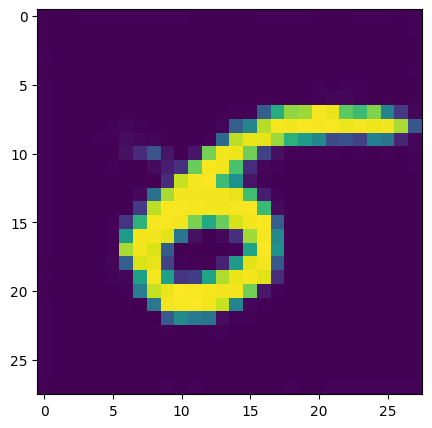

In [25]:
total_loss = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for i, x1 in tqdm(enumerate(loader), desc=f"Epoch {epoch+1}"):
        x1 = x1.to(device)
        t = torch.rand(x1.shape[0]).to(device)
        x0 = torch.randn_like(x1).to(device)
        loss = fm.criterion(t, x0, x1)
        epoch_loss += loss.detach().cpu().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    total_loss.append(epoch_loss/(i+1))
    if epoch % 1 == 0:
        print(f"Total Loss Epoch {epoch+1}: ", total_loss[-1])
    sample=fm.sample(1)
    sample = sample.detach().cpu().numpy()
    plt.figure(figsize=(5, 5))
    plt.imshow(sample[0, 0])
    plt.show()


In [26]:
samples = (fm.sample(32)*0.5+0.5).detach().cpu().numpy()

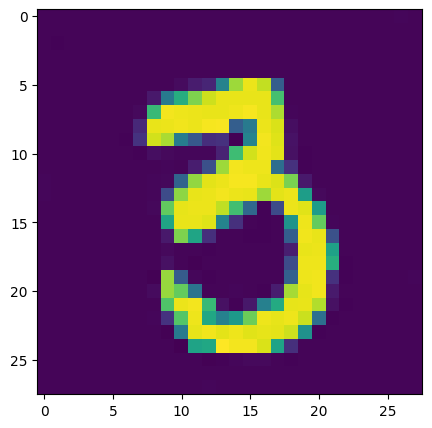

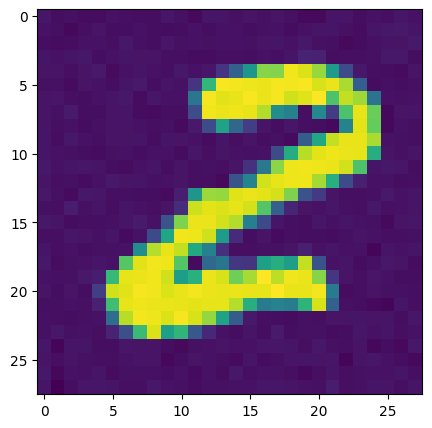

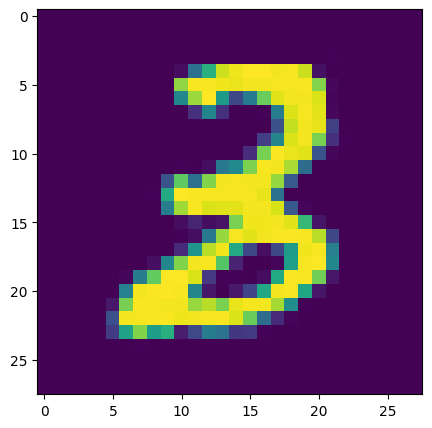

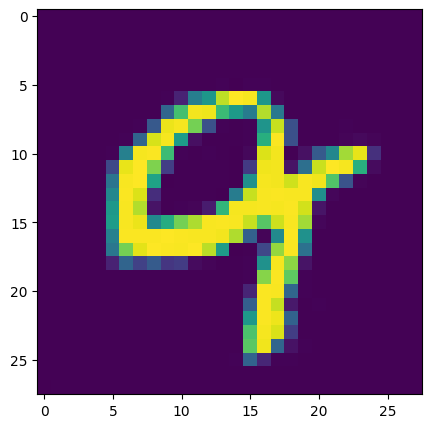

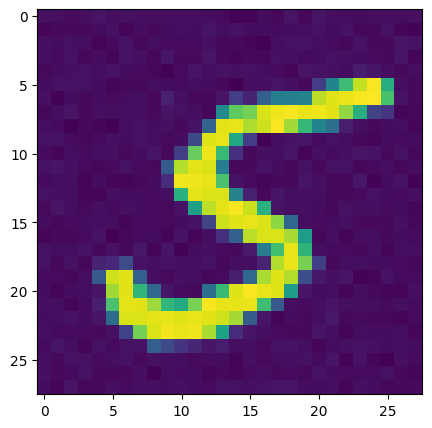

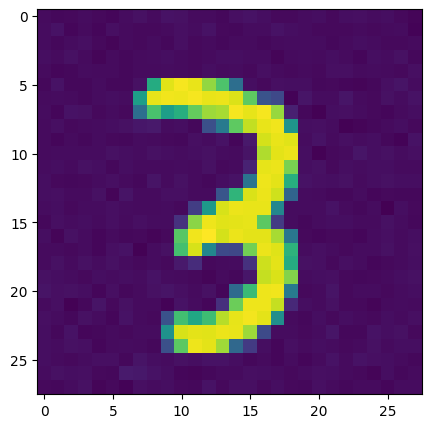

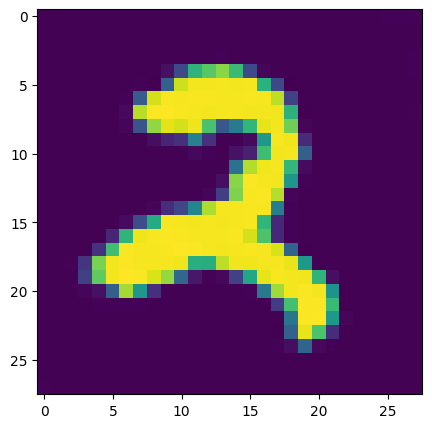

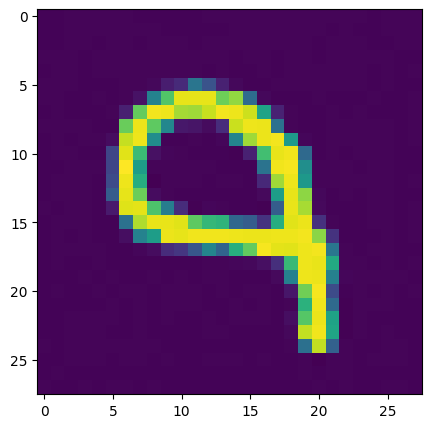

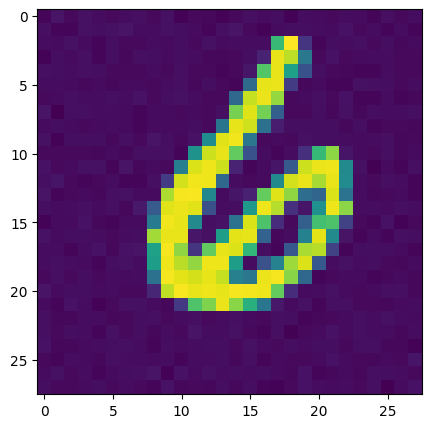

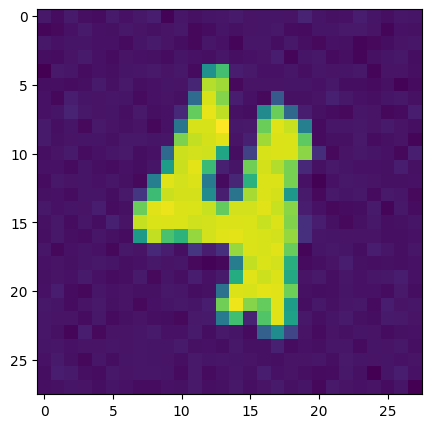

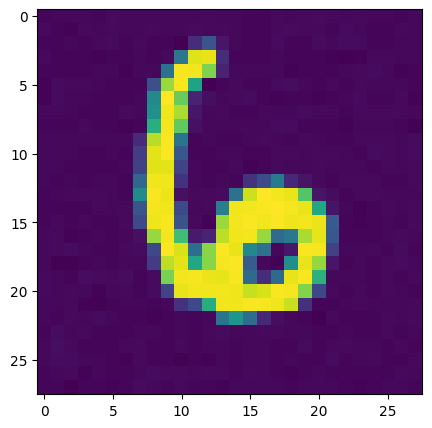

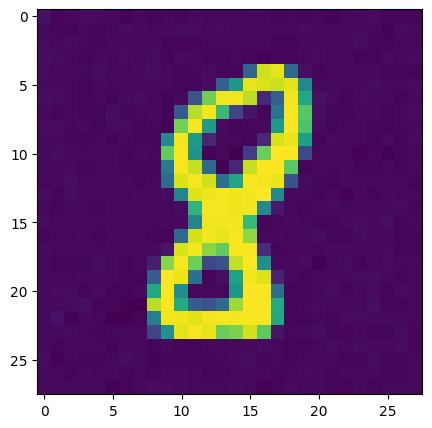

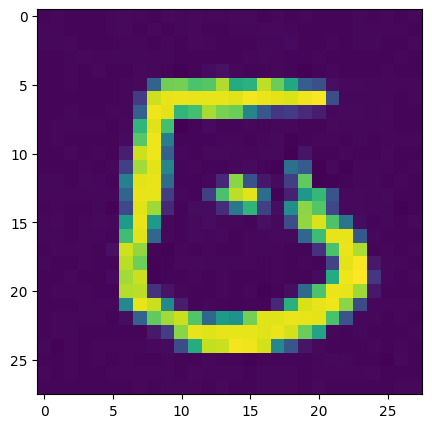

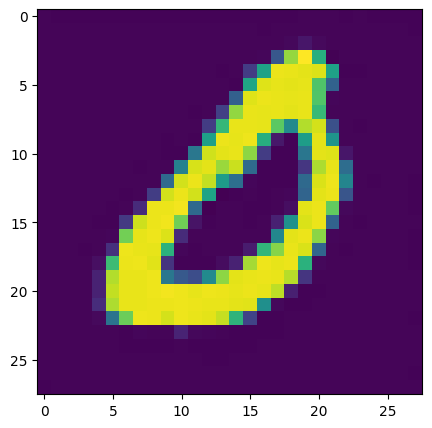

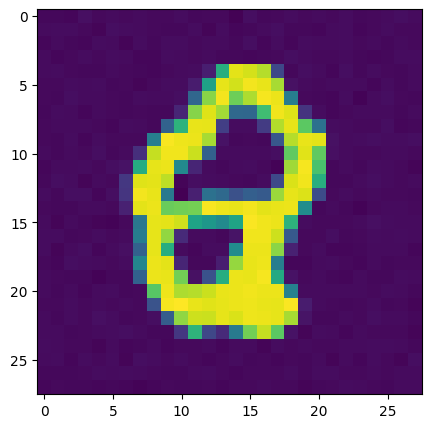

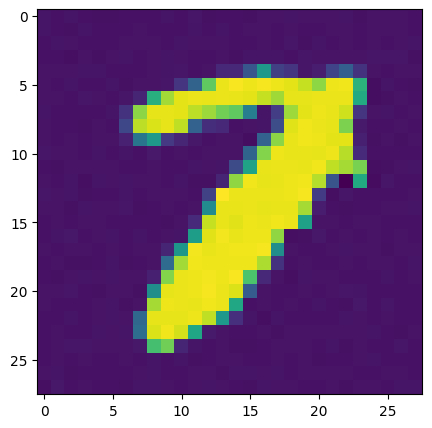

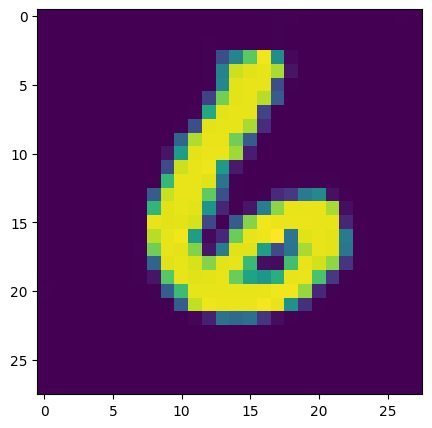

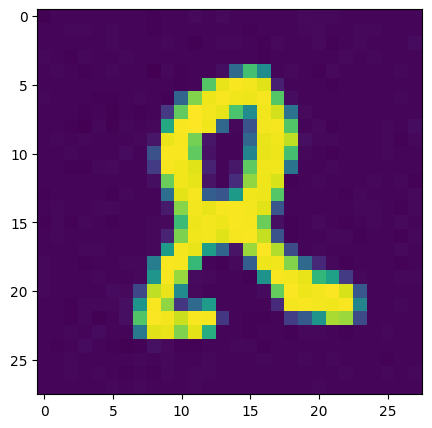

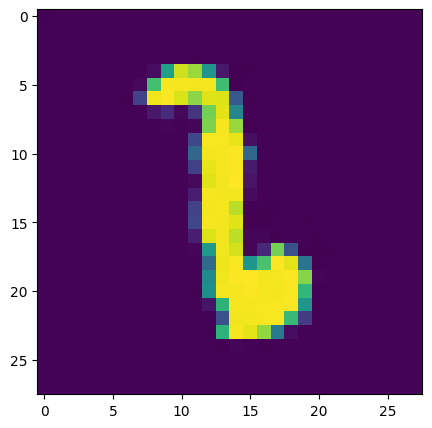

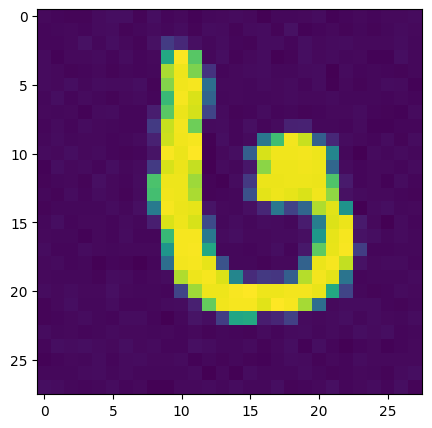

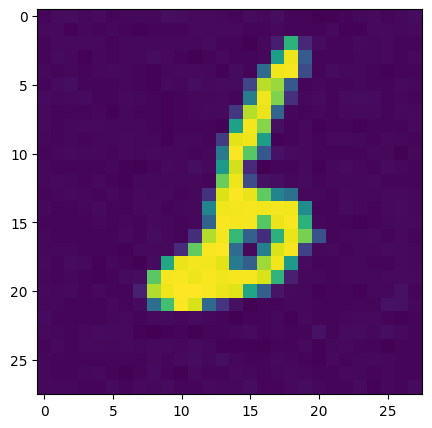

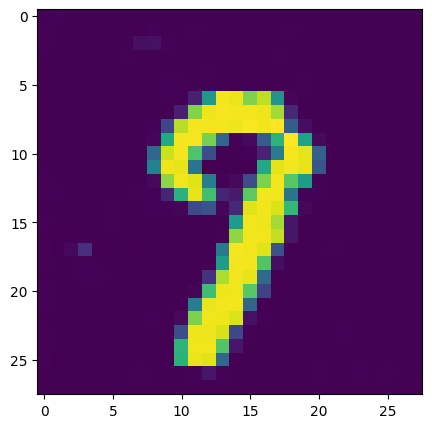

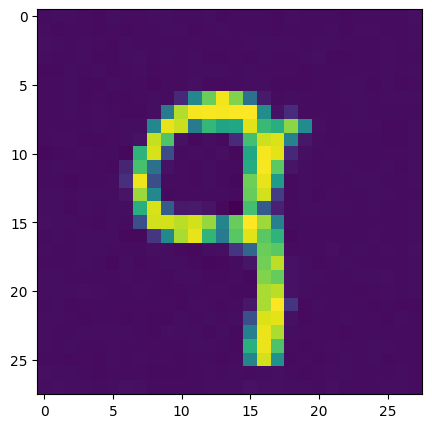

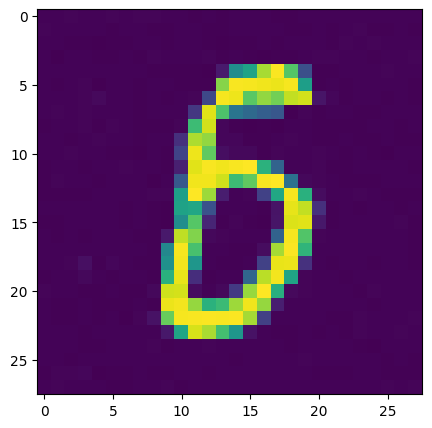

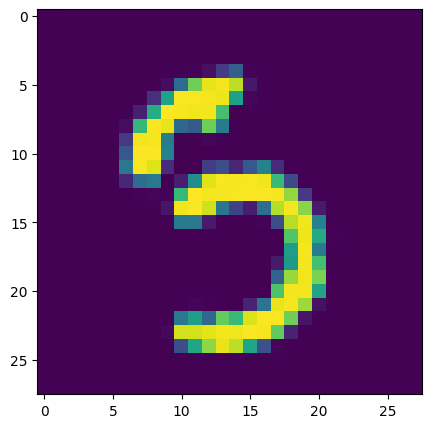

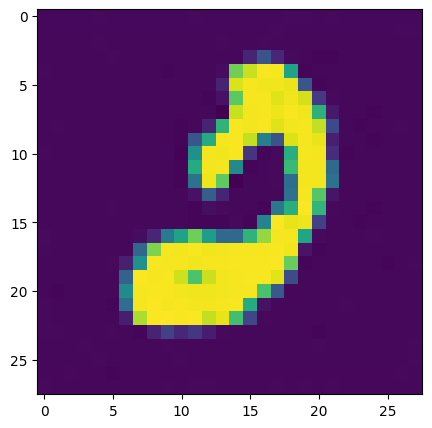

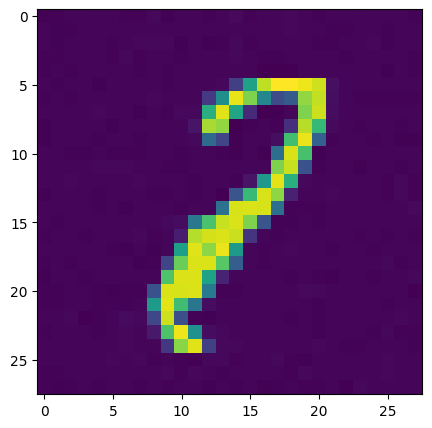

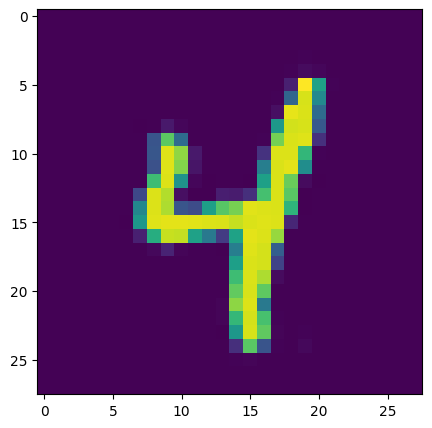

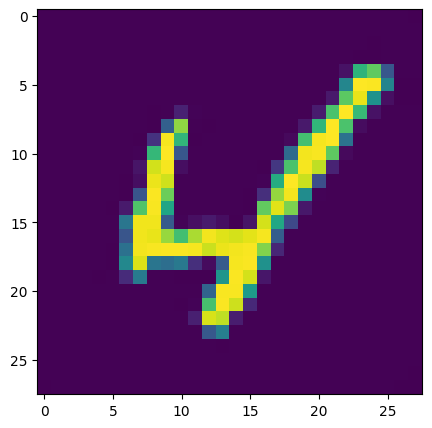

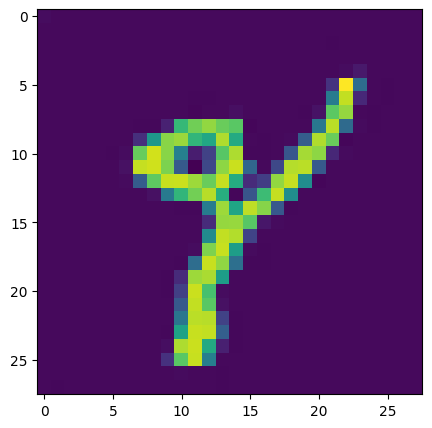

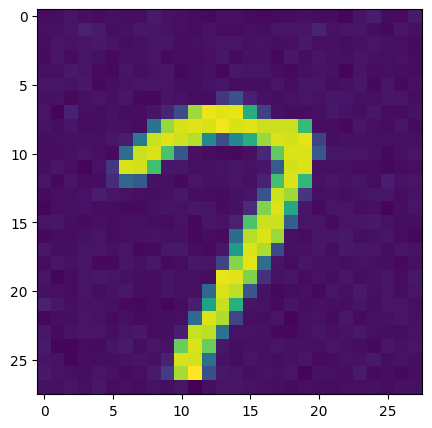

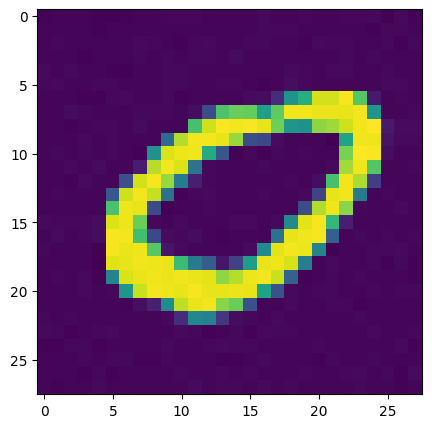

In [27]:
for i in range(samples.shape[0]):
    plt.figure(figsize=(5, 5))
    plt.imshow(samples[i, 0])
    plt.show()

In [28]:
samples.max()

np.float32(1.0985355)